In [1]:
import random
import torch
import pickle

import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_steps = 1000
seed = 0
hidden_dims = {'F'}
lookback = 1
train_eps = 1000

random.seed(seed)
torch.manual_seed(seed)

In [4]:
expert_env = AntMazePCH(num_steps=num_steps, hidden_dims=set(), seed=seed)

In [5]:
env = AntMazePCH(num_steps=num_steps, hidden_dims=hidden_dims, seed=seed)

In [6]:
# to save time; conceptually the same
small_steps = lookback + 1
small_env = AntMazePCH(num_steps=small_steps, hidden_dims=hidden_dims, seed=seed)
G = parse_graph(small_env.get_graph)
X_small = {f'X{t}' for t in range(small_steps)}
Y = f'Y{small_steps}'

# G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [7]:
Z_sets = find_sequential_pi_backdoor(G, X_small, Y, obs_prefix)

base_step = small_steps - 1
base_Z_set = Z_sets[f'X{base_step}']

for i in range(base_step + 1, num_steps):
    updated_base_Z_set = set()
    for v in base_Z_set:
        updated_base_Z_set.add(f'{v[0]}{int(v[1:]) + i - lookback}')

    Z_sets[f'X{i}'] = updated_base_Z_set

In [8]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

In [9]:
# load expert
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt'
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

expert = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

expert.load_state_dict(checkpoint['state_dict'])
expert.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

def make_ft_policies_with_F(model, slots, Z_trim, device, num_steps, extra_vars):
    policies = {}
    for t in range(num_steps):
        def pi_t(obs, t=t):
            state = build_state_feature(obs, t, Z_trim, slots, device, extra_vars=extra_vars)

            with torch.no_grad():
                action = model(state).squeeze(0).cpu().numpy().astype(np.float32)

            return action
        
        policies[f'X{t}'] = pi_t

    return policies

expert_policies = make_ft_policies_with_F(
    expert,
    slots=slots,
    Z_trim=Z_trim,
    device=device,
    num_steps=num_steps,
    extra_vars={'F'}
)

In [ ]:
records = collect_imitator_trajectories(
    expert_env,
    expert_policies,
    num_episodes=train_eps,
    max_steps=num_steps,
    seed=seed,
    hidden_dims=hidden_dims,
    show_progress=True
)

Starting episode 1/1000...
  Episode 1 ended at step 491 (terminated: True, truncated: False).
Starting episode 2/1000...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/1000...
  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...
  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/1000...
  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/1000...
  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/1000...
  Episode 7 ended at step 355 (terminated: True, truncated: False).
Starting episode 8/1000...
  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/1000...
  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/1000...
  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/1000...
  Episode 11

In [11]:
# with open('/home/et2842/causal/expert_traj.pkl', 'wb') as f:
#     pickle.dump(records, f)

# print(f'saved {len(records)} trajectories')

In [12]:
# with open('/home/et2842/causal/expert_traj.pkl', 'rb') as f:
#     records = pickle.load(f)

# print(f'loaded {len(records)} trajectories')

In [13]:
hidden_size = 256
lr = 3e-4
batch_size = 2048
patience = 15
num_blocks = 4
epochs = 100
dropout = 0.0

dims = {
    'P': 3,
    'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    # 'F': 2,
    'W': 1,
    'X': 8
}

In [14]:
causal_model, causal_slots, causal_Z_trim = train_single_policy_long_horizon(
    records,
    Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

causal_policy = shared_policy_fn_long_horizon(causal_model, causal_slots, causal_Z_trim, continuous=True, device=device)
causal_policies = make_shared_policy_dict(causal_policy)

[LongHorizon] Epoch 1: train loss = 0.039432, val loss = 0.012980.
[LongHorizon] Epoch 2: train loss = 0.010320, val loss = 0.008325.
[LongHorizon] Epoch 3: train loss = 0.007313, val loss = 0.006597.
[LongHorizon] Epoch 4: train loss = 0.005939, val loss = 0.005706.
[LongHorizon] Epoch 5: train loss = 0.005112, val loss = 0.005031.
[LongHorizon] Epoch 6: train loss = 0.004526, val loss = 0.004478.
[LongHorizon] Epoch 7: train loss = 0.004115, val loss = 0.004022.
[LongHorizon] Epoch 8: train loss = 0.003800, val loss = 0.003936.
[LongHorizon] Epoch 9: train loss = 0.003555, val loss = 0.003686.
[LongHorizon] Epoch 10: train loss = 0.003292, val loss = 0.003325.
[LongHorizon] Epoch 11: train loss = 0.003113, val loss = 0.003347.
[LongHorizon] Epoch 12: train loss = 0.002984, val loss = 0.003205.
[LongHorizon] Epoch 13: train loss = 0.002832, val loss = 0.002990.
[LongHorizon] Epoch 14: train loss = 0.002704, val loss = 0.002874.
[LongHorizon] Epoch 15: train loss = 0.002584, val loss =

In [15]:
naive_model, naive_slots, naive_Z_trim = train_single_policy_long_horizon(
    records,
    naive_Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

naive_policy = shared_policy_fn_long_horizon(naive_model, naive_slots, naive_Z_trim, continuous=True, device=device)
naive_policies = make_shared_policy_dict(naive_policy)

[LongHorizon] Epoch 1: train loss = 0.039333, val loss = 0.013040.
[LongHorizon] Epoch 2: train loss = 0.010344, val loss = 0.008532.
[LongHorizon] Epoch 3: train loss = 0.007371, val loss = 0.006520.
[LongHorizon] Epoch 4: train loss = 0.005977, val loss = 0.005661.
[LongHorizon] Epoch 5: train loss = 0.005168, val loss = 0.005196.
[LongHorizon] Epoch 6: train loss = 0.004584, val loss = 0.004465.
[LongHorizon] Epoch 7: train loss = 0.004153, val loss = 0.004123.
[LongHorizon] Epoch 8: train loss = 0.003846, val loss = 0.003900.
[LongHorizon] Epoch 9: train loss = 0.003556, val loss = 0.003665.
[LongHorizon] Epoch 10: train loss = 0.003327, val loss = 0.003412.
[LongHorizon] Epoch 11: train loss = 0.003148, val loss = 0.003398.
[LongHorizon] Epoch 12: train loss = 0.003004, val loss = 0.003218.
[LongHorizon] Epoch 13: train loss = 0.002865, val loss = 0.003019.
[LongHorizon] Epoch 14: train loss = 0.002733, val loss = 0.002908.
[LongHorizon] Epoch 15: train loss = 0.002610, val loss =

Starting episode 1/1000...
  Episode 1 ended at step 401 (terminated: True, truncated: False).
Starting episode 2/1000...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/1000...
  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...
  Episode 4 ended at step 247 (terminated: True, truncated: False).
Starting episode 5/1000...
  Episode 5 ended at step 384 (terminated: True, truncated: False).
Starting episode 6/1000...
  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/1000...
  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/1000...
  Episode 8 ended at step 333 (terminated: True, truncated: False).
Starting episode 9/1000...
  Episode 9 ended at step 427 (terminated: True, truncated: False).
Starting episode 10/1000...
  Episode 10 ended at step 376 (terminated: True, truncated: False).
Starting episode 11/1000...
  Episode 11 end

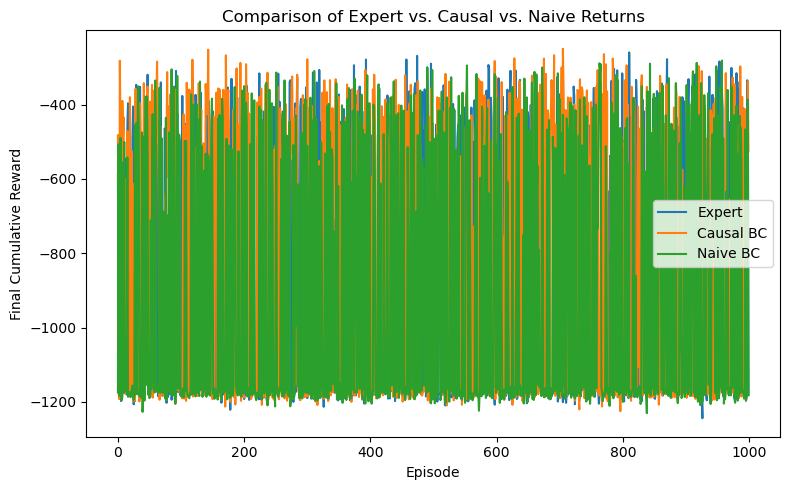

In [ ]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

causal_records = collect_imitator_trajectories(
    env,
    causal_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_episode_rewards = defaultdict(float)
for rec in causal_records:
    ep = rec['episode']
    causal_episode_rewards[ep] += float(rec['reward'])

causal_rewards = [causal_episode_rewards[e] for e in range(num_eps)]

naive_records = collect_imitator_trajectories(
    env,
    naive_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_episode_rewards = defaultdict(float)
for rec in naive_records:
    ep = rec['episode']
    naive_episode_rewards[ep] += float(rec['reward'])

naive_rewards = [naive_episode_rewards[e] for e in range(num_eps)]

plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert')
plt.plot(causal_rewards, label='Causal BC')
plt.plot(naive_rewards, label='Naive BC')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert vs. Causal vs. Naive Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
sum(expert_rewards)/num_eps, sum(causal_rewards)/num_eps, sum(naive_rewards)/num_eps

(-874.9105466270786, -871.9924644848212, -908.1941878408231)

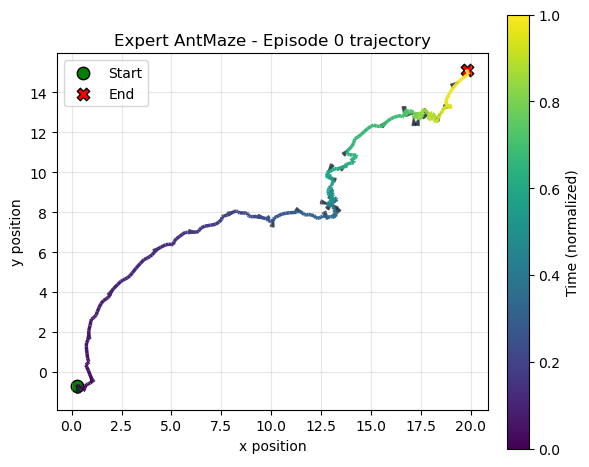

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

fig, ax = plot_ant_trajectory_xy(records, episode_id=0, title_prefix='Expert AntMaze')
plt.show()

In [25]:
i = 0

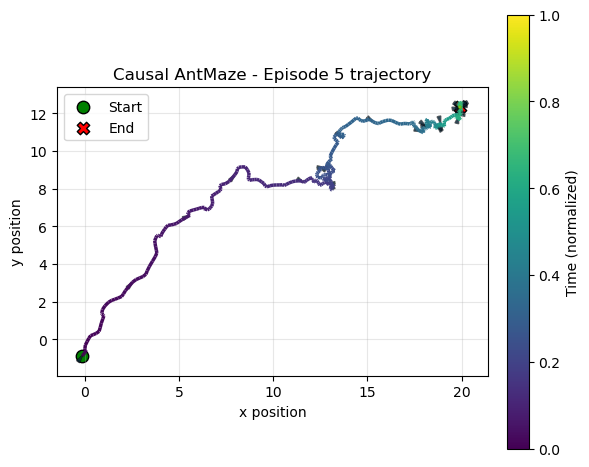

In [31]:
fig, ax = plot_ant_trajectory_xy(causal_records, episode_id=i % 10, title_prefix='Causal AntMaze')
plt.show()
i += 1

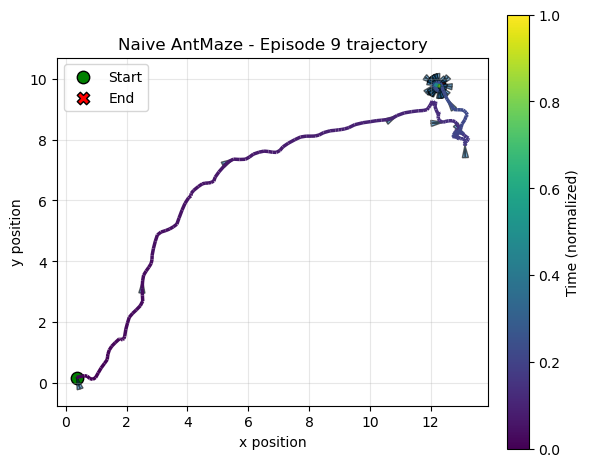

In [35]:
fig, ax = plot_ant_trajectory_xy(naive_records, episode_id=i % 10, title_prefix='Naive AntMaze')
plt.show()
i += 1